# Traveling Salesman Problem

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/milp_path.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This example shows how an optimization can be used to solve a Traveling Salesman Problem over a roadmap.

First we'll need some libraries including the [PuLP linear programming library](https://coin-or.github.io/pulp/).

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
!pip install pulp
from pulp import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Problem definition

Start by choosing 20 random locations.

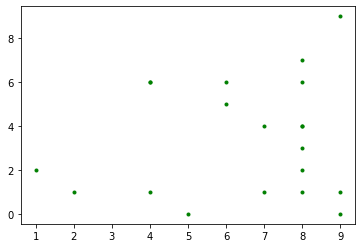

In [12]:
visit_points = np.array([[random.randrange(0,10), random.randrange(0,10)] for ii in range(20)])

plt.plot(visit_points[:,0], visit_points[:,1],'g.')
plt.show()

Now find the distances between them.  For simplicyt, I'll use straight line between all involved.  You could have `inf` values in here as well though - for example, the adjacency graph from any of the roadmap methods could be used.

In [13]:
from math import sqrt
distance = np.zeros((20,20))
for ii in range(20):
  for jj in range(ii,20):
    distance[ii,jj] = sqrt(sum((visit_points[ii,:]-visit_points[jj,:])**2))
    distance[jj,ii]=distance[ii,jj]
distance

array([[ 0.        ,  5.09901951,  2.23606798,  2.        ,  4.47213595,
         4.12310563,  1.        ,  3.16227766,  5.        ,  4.47213595,
         6.70820393,  0.        ,  1.        ,  3.        ,  7.28010989,
         3.16227766,  3.        ,  2.82842712,  2.        ,  5.        ],
       [ 5.09901951,  0.        ,  5.        ,  3.16227766,  5.83095189,
         9.        ,  5.38516481,  8.24621125,  9.43398113,  5.83095189,
        10.63014581,  5.09901951,  6.08276253,  2.23606798, 10.63014581,
         8.        ,  8.06225775,  4.24264069,  7.07106781,  9.8488578 ],
       [ 2.23606798,  5.        ,  0.        ,  2.23606798,  2.23606798,
         5.83095189,  1.41421356,  4.12310563,  4.47213595,  2.23606798,
         5.65685425,  2.23606798,  2.82842712,  2.82842712,  5.83095189,
         5.        ,  4.47213595,  1.        ,  3.60555128,  5.09901951],
       [ 2.        ,  3.16227766,  2.23606798,  0.        ,  4.        ,
         6.08276253,  2.23606798,  5.09901951,  

## The TSP bit

Now we've built the roadmap, instead of running an A-to-B search like Dijkstra's on it, let's find the shortest path that visits all points.

We solve this using integer linear optimization, using a library called PuLP to model and solve the problem.  First, get a list of all the possible moves or "links" and create a new optimization problem with a binary decision variable for each, $X(i,j) = \{0,1\} \ \forall i \ne j$.  We will intepret $X(i,j)=1$ to mean that the shortest path goes from $i$ to $j$.

In [14]:
n = len(visit_points)
links = [(i,j) for i in range(n) for j in range(n) if j!=i]

prob = LpProblem('tsp',LpMinimize)
x = LpVariable.dicts("x",links,0,1,LpInteger)

Define the objective to be the length of the path, which is the sum of all the decision variables weighted by the length of each link, $\sum_{i,j \ i \ne j} D(i,j)X(i,j)$. 

In [15]:
prob.setObjective(sum([distance[i,j]*x[i,j] for (i,j) in links]))


The main constraints are that the path must depart from every node exactly once $\sum_{j \in \mathcal{N}(i)} X(i,j) = 1 \ \forall i$ and also arrive at every node exactly once $\sum_{i  \in \mathcal{N}(j)} X(i,j)=1 \ \forall j$ where $\mathcal{N}(n)$ denotes the nodes connected to node $n$, in our case every other node.

In [16]:
for i in range(n):
    prob += (sum(x[ic,j] for (ic,j) in links if ic==i)==1)
for j in range(n):
    prob += (sum(x[i,jc] for (i,jc) in links if jc==j)==1)

One last issue: we could satisfy the constraints so far with two (or more) disconnected circuits or _tours_, provided the two covered all the nodes between them.  This isn;t what we're looking for.  There are various approaches to solving _the subtour problem_ but here we'll use extra variables $V(i)$ to extract the ordering of the visits, with a constraint ensuring $V(j) = V(i)+1$ if $X(i,j)=1$ for every $j>0$.  A subtour not including node $0$ would contradict this constraint as the ordering constraints would be circular: $3>2>1>3$.

In [17]:
v = LpVariable.dicts("v",range(n),0,n)
for (i,j) in links:
    if j!=0:
        prob += (v[j]>=v[i]+1-n*(1-x[i,j])) 

We can take a look at the problem and while it is pretty ugly, look closely and you can identify the elements of the model.

In [18]:
prob

tsp:
MINIMIZE
5.0990195135927845*x_(0,_1) + 6.708203932499369*x_(0,_10) + 1.0*x_(0,_12) + 3.0*x_(0,_13) + 7.280109889280518*x_(0,_14) + 3.1622776601683795*x_(0,_15) + 3.0*x_(0,_16) + 2.8284271247461903*x_(0,_17) + 2.0*x_(0,_18) + 5.0*x_(0,_19) + 2.23606797749979*x_(0,_2) + 2.0*x_(0,_3) + 4.47213595499958*x_(0,_4) + 4.123105625617661*x_(0,_5) + 1.0*x_(0,_6) + 3.1622776601683795*x_(0,_7) + 5.0*x_(0,_8) + 4.47213595499958*x_(0,_9) + 5.0990195135927845*x_(1,_0) + 10.63014581273465*x_(1,_10) + 5.0990195135927845*x_(1,_11) + 6.082762530298219*x_(1,_12) + 2.23606797749979*x_(1,_13) + 10.63014581273465*x_(1,_14) + 8.0*x_(1,_15) + 8.06225774829855*x_(1,_16) + 4.242640687119285*x_(1,_17) + 7.0710678118654755*x_(1,_18) + 9.848857801796104*x_(1,_19) + 5.0*x_(1,_2) + 3.1622776601683795*x_(1,_3) + 5.830951894845301*x_(1,_4) + 9.0*x_(1,_5) + 5.385164807134504*x_(1,_6) + 8.246211251235321*x_(1,_7) + 9.433981132056603*x_(1,_8) + 5.830951894845301*x_(1,_9) + 6.708203932499369*x_(10,_0) + 10.630145812734

Now we simply as PuLP to solve it and look at the result.

In [19]:
prob.solve()
print("Status:", LpStatus[prob.status])
[(i,j,x[i,j].value()) for (i,j) in links]

Status: Optimal


[(0, 1, 0.0),
 (0, 2, 0.0),
 (0, 3, 0.0),
 (0, 4, 0.0),
 (0, 5, 0.0),
 (0, 6, 0.0),
 (0, 7, 0.0),
 (0, 8, 0.0),
 (0, 9, 0.0),
 (0, 10, 0.0),
 (0, 11, 1.0),
 (0, 12, 0.0),
 (0, 13, 0.0),
 (0, 14, 0.0),
 (0, 15, 0.0),
 (0, 16, 0.0),
 (0, 17, 0.0),
 (0, 18, 0.0),
 (0, 19, 0.0),
 (1, 0, 0.0),
 (1, 2, 0.0),
 (1, 3, 0.0),
 (1, 4, 0.0),
 (1, 5, 0.0),
 (1, 6, 0.0),
 (1, 7, 0.0),
 (1, 8, 0.0),
 (1, 9, 0.0),
 (1, 10, 0.0),
 (1, 11, 0.0),
 (1, 12, 0.0),
 (1, 13, 1.0),
 (1, 14, 0.0),
 (1, 15, 0.0),
 (1, 16, 0.0),
 (1, 17, 0.0),
 (1, 18, 0.0),
 (1, 19, 0.0),
 (2, 0, 0.0),
 (2, 1, 0.0),
 (2, 3, 0.0),
 (2, 4, 0.0),
 (2, 5, 0.0),
 (2, 6, 0.0),
 (2, 7, 0.0),
 (2, 8, 0.0),
 (2, 9, 0.0),
 (2, 10, 0.0),
 (2, 11, 0.0),
 (2, 12, 0.0),
 (2, 13, 0.0),
 (2, 14, 0.0),
 (2, 15, 0.0),
 (2, 16, 0.0),
 (2, 17, 1.0),
 (2, 18, 0.0),
 (2, 19, 0.0),
 (3, 0, 0.0),
 (3, 1, 0.0),
 (3, 2, 0.0),
 (3, 4, 0.0),
 (3, 5, 0.0),
 (3, 6, 1.0),
 (3, 7, 0.0),
 (3, 8, 0.0),
 (3, 9, 0.0),
 (3, 10, 0.0),
 (3, 11, 0.0),
 (3, 12, 0.0),
 

Plot the results and we should have an efficient tour round all the points.

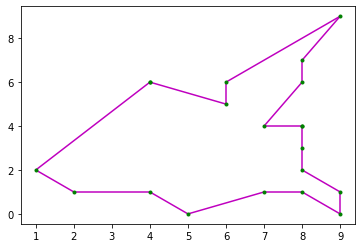

In [20]:
for (ii,jj) in links:
    if x[ii,jj].value()==1.:
        plt.plot([visit_points[ii,0],visit_points[jj,0]],[visit_points[ii,1],visit_points[jj,1]],'m-')
plt.plot(visit_points[:,0], visit_points[:,1],'g.')
plt.show()